In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import sys
from tqdm import tqdm

In [4]:
config_file = 'config_kdv.json'

with open(config_file, 'r') as f:
    config = json.load(f)

In [5]:
data_path = config['data_settings']['data_path']
weights_path = config['nn_settings']['weights_path']

n_init = config['data_settings']['n_init']
traj_len = config['data_settings']['traj_len']

forcing_type = config['data_settings']['forcing_type']



n_psi_train = config['nn_settings']['n_psi_train']
dict_layer_size = config['nn_settings']['dict_layer_size']
K_layer_size = config['nn_settings']['K_layer_size']

In [6]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
from koopmanlib.functions import *

In [22]:
from koopmanlib.target import KortewegDeVriesTarget

In [9]:
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)

# inner loop
# # Set the time sample grid.
# dt = 0.4 / (Nx**2)
T = 0.01
# Nt = int(T / dt)
# dt = T / Nt
# t = np.linspace(0, T, Nt)

In [10]:
def v_func(x, c):
    return np.exp(-25 * (x - c)**2)

c1, c2, c3 = -np.pi/2, 0, np.pi/2
v1 = v_func(x, c1).reshape(1,-1)
v2 = v_func(x, c2).reshape(1,-1)
v3 = v_func(x, c3).reshape(1,-1)

v_list = np.concatenate([v1,v2,v3], axis=0)

In [11]:
umax = 1
umin = -umax

target_dim = Nx
param_dim = 3

In [12]:
kdv = KortewegDeVriesTarget(n_init=n_init,
            traj_len=traj_len,
            x=x,
            t_step=T,
            dim=Nx,
            param_dim=param_dim,
            forcing_type='sin',
            v_list=v_list,
            L=L)

In [13]:
dict_data = np.load(os.path.join(data_path,'data_kdv_'+forcing_type+'.npy'), allow_pickle=True)

# Build model

## PK-NN

In [14]:
from koopmanlib.dictionary import PsiNN_obs
from koopmanlib.param_solver import KoopmanParametricDLSolver

from tensorflow.keras.optimizers import Adam

n_psi = 1 + 1 + 1 + n_psi_train # constant + momentum + mean + NN

dic_pk = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

solver_pk = KoopmanParametricDLSolver(target_dim=target_dim, 
                                      param_dim=param_dim, 
                                      n_psi=n_psi,
                                      dic=dic_pk)

model_pk, model_K_u_pred_pk = solver_pk.generate_model(layer_sizes=K_layer_size)

model_pk.load_weights(os.path.join(weights_path,'pk_kdv_weights_'+forcing_type+'.h5'))

In [ ]:
def compute_pk_obs(y0, param_list, B_obs):
    param = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1,-1)
    
    psi_y = dic_pk(y0)
    obs_list = [psi_y@B_obs]
    
    tau = param_list.shape[0]

    for i in range(tau):
        psi_y = model_K_u_pred_pk([param[i], psi_y])
        obs_next = psi_y@B_obs
        obs_list.append(obs_next)
        
    return np.squeeze(np.asarray(obs_list))

## Linear

In [59]:
from koopmanlib.param_solver import KoopmanLinearDLSolver

dic_linear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)
solver_linear = KoopmanLinearDLSolver(dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)

model_linear = solver_linear.build_model()

solver_linear.model.load_weights(os.path.join(weights_path, 'linear_kdv_weights_'+forcing_type+'.h5'))


In [62]:
def compute_linear_obs(y0, param_list, B_obs):
    param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1,-1)
    psi_y = solver_linear.dic.call(y0)
    obs_list = [psi_y@B_obs]
    
    for param in param_list:
        psi_y = solver_linear.model.get_layer('Layer_A')(psi_y) + solver_linear.model.get_layer('Layer_B')(param)
        obs_next = psi_y@B_obs
        obs_list.append(obs_next)
        
    return np.squeeze(np.asarray(obs_list))

## Bilinear

In [64]:
from koopmanlib.param_solver import KoopmanBilinearDLSolver
dic_bilinear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

solver_bilinear = KoopmanBilinearDLSolver(dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)

model_bilinear = solver_bilinear.build_model()

In [65]:
solver_bilinear.model.load_weights(os.path.join(weights_path, 'bilinear_kdv_weights_'+forcing_type+'.h5'))

In [66]:
def compute_bilinear_obs(y0, param_list, B_obs):
    param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1,-1)
    psi_y = solver_bilinear.dic.call(y0)
    obs_list = [psi_y@B_obs]
    
    for param in param_list:
        u_psiy = tf.einsum('ij,ik->kij', psi_y, param)
        u_psiy_list = []
        for curr in u_psiy:
            u_psiy_list.append(curr)
        u_psiy_list = tf.concat(u_psiy_list, axis=-1)
        
        psi_y = solver_bilinear.model.get_layer('Layer_A')(psi_y) + solver_bilinear.model.get_layer('Layer_B')(u_psiy_list)
        obs_next = psi_y@B_obs
        obs_list.append(obs_next)
        
    return np.squeeze(np.asarray(obs_list))

# Testing problems

In [123]:
# Plot setting
linear_curve = 'darkorange'
linear_shadow = 'navajowhite'
bilinear_curve = 'forestgreen'
bilinear_shadow = 'darkseagreen'
pk_curve = 'darkslateblue'
pk_shadow = 'lightsteelblue'
ref_color = 'black'


exact_color = 'darkred'
linear_no_penalty_color = 'gold'
bilinear_no_penalty_color = 'turquoise'
pk_no_penalty_color = 'palevioletred'

label_font = 24
ticks_font = 22
legend_font = 24
linewidth = 2.5
title_font = 16

linear_linestyle = 'dashdot'
bilinear_linestyle = 'dotted'
pk_linestyle = 'solid'

## Prediction

In [67]:


def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv.kdv_solution(y0_loop, T, param)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list

In [68]:
pred_traj_number = 5
np.random.seed(12)
seed_list = np.random.randint(low=1, high=200, size=(pred_traj_number,2))

y0_pred_list=[]
param_pred_list = []

Tsim_pred = 0.1
traj_len_pred = int(Tsim_pred / T)

for seed_IC, seed_u in seed_list:
    # Forward prediction problem setting
    y0_pred = kdv.generate_y0(seed_IC) 
    

    # Set the seed of param_list
    np.random.seed(seed_u)

    param_pred = np.random.uniform(low=0, high=1, size=(traj_len_pred, param_dim)) * (umax - umin) + umin
    
    y0_pred_list.append(y0_pred)
    param_pred_list.append(param_pred)

In [24]:
error_mass_list_pk, error_momentum_list_pk = kdv.compute_obs_error(dic=dic_pk,
                                                           compute_kdv_soln_func=compute_kdv_soln,
                                                           compute_obs_func_model=compute_pk_obs,
                                                           error_func=compute_diff_ratio_one_traj,
                                                           y0_pred_list=y0_pred_list,
                                                           param_pred_list=param_pred_list,
                                                           dx=dx)

mass_mean_pk, mass_std_pk, mass_mean_plus_pk, mass_mean_minus_pk = compute_stat_info(error_mass_list_pk)
momentum_mean_pk, momentum_std_pk, momentum_mean_plus_pk, momentum_mean_minus_pk = compute_stat_info(error_momentum_list_pk)

In [69]:
error_mass_list_linear, error_momentum_list_linear = kdv.compute_obs_error(dic=dic_linear,
                                                               compute_kdv_soln_func=compute_kdv_soln,
                                                               compute_obs_func_model=compute_linear_obs,
                                                               error_func=compute_diff_ratio_one_traj,
                                                               y0_pred_list=y0_pred_list,
                                                               param_pred_list=param_pred_list,
                                                               dx=dx)
mass_mean_linear, mass_std_linear, mass_mean_plus_linear, mass_mean_minus_linear = compute_stat_info(error_mass_list_linear)
momentum_mean_linear, momentum_std_linear, momentum_mean_plus_linear, momentum_mean_minus_linear = compute_stat_info(error_momentum_list_linear)

In [70]:
error_mass_list_bilinear, error_momentum_list_bilinear = kdv.compute_obs_error(dic=dic_bilinear,
                                                               compute_kdv_soln_func=compute_kdv_soln,
                                                               compute_obs_func_model=compute_bilinear_obs,
                                                               error_func=compute_diff_ratio_one_traj,
                                                               y0_pred_list=y0_pred_list,
                                                               param_pred_list=param_pred_list,
                                                               dx=dx)
mass_mean_bilinear, mass_std_bilinear, mass_mean_plus_bilinear, mass_mean_minus_bilinear = compute_stat_info(error_mass_list_bilinear)
momentum_mean_bilinear, momentum_std_bilinear, momentum_mean_plus_bilinear, momentum_mean_minus_bilinear = compute_stat_info(error_momentum_list_bilinear)

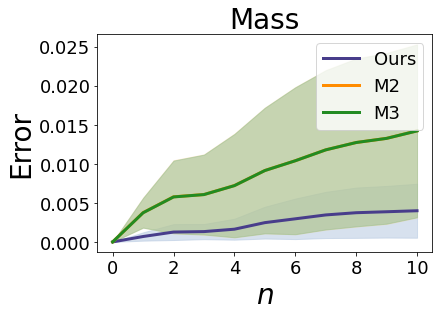

In [94]:
t_axis = np.arange(0, traj_len_pred+1, 1)

plt.title('Mass', fontsize=28)
plt.plot(mass_mean_pk, label='Ours', color=pk_curve, linewidth=3)
plt.fill_between(t_axis, np.maximum(mass_mean_minus_pk,0), mass_mean_plus_pk, color=pk_shadow, alpha=0.5)

plt.plot(mass_mean_linear, label='M2', color=linear_curve, linewidth=3)
plt.fill_between(t_axis, np.maximum(mass_mean_minus_linear,0), mass_mean_plus_linear, color=linear_shadow, alpha=0.5)

plt.plot(mass_mean_bilinear, label='M3', color=bilinear_curve, linewidth=3)
plt.fill_between(t_axis, np.maximum(mass_mean_minus_bilinear,0), mass_mean_plus_bilinear, color=bilinear_shadow, alpha=0.5)

plt.xlabel(r'$n$', fontsize=28)
plt.ylabel('Error', fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

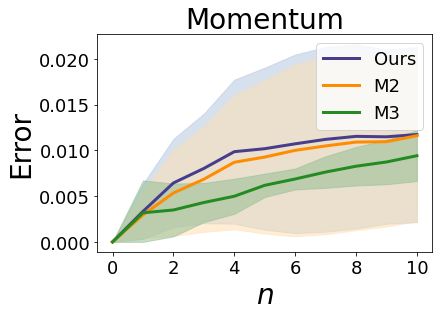

In [95]:
t_axis = np.arange(0, traj_len_pred+1, 1)

plt.title('Momentum', fontsize=28)
plt.plot(momentum_mean_pk, label='Ours', color=pk_curve, linewidth=3)
plt.fill_between(t_axis, np.maximum(momentum_mean_minus_pk,0), momentum_mean_plus_pk, color=pk_shadow, alpha=0.5)

plt.plot(momentum_mean_linear, label='M2', color=linear_curve, linewidth=3)
plt.fill_between(t_axis, np.maximum(momentum_mean_minus_linear,0), momentum_mean_plus_linear, color=linear_shadow, alpha=0.5)

plt.plot(momentum_mean_bilinear, label='M3', color=bilinear_curve, linewidth=3)
plt.fill_between(t_axis, np.maximum(momentum_mean_minus_bilinear,0), momentum_mean_plus_bilinear, color=bilinear_shadow, alpha=0.5)

plt.xlabel(r'$n$', fontsize=28)
plt.ylabel('Error', fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

# Tracking problem

In [78]:
from scipy.optimize import minimize

In [79]:
# Testing reference
y0_track = np.zeros(shape=(Nx, )) + 0.2

In [80]:
Tsim_track = 10

traj_len_track = int(Tsim_track / T)

### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim))+0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5

In [81]:
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1,1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1,1))

In [82]:
def mpc_loss_pk(param, tau, ref_list, y0, B, lambda_param):
    param = tf.reshape(param, shape=(int(param.shape[0]/param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1,-1)
    psi_y = dic_pk(y0)
    
    for i in range(tau):
        psi_x = model_K_u_pred_pk([param[i], psi_y])
        obs_next = psi_x@B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)
    
    ref_loss= tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))
    
    loss = ref_loss + param_loss
    
    return loss 

def mpc_loss_linear(param, tau, ref_list, y0, B, lambda_param):
    param = tf.reshape(param, shape=(int(param.shape[0]/param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1,-1)
    psi_y = solver_linear.dic.call(y0)
    
    for i in range(tau):
        psi_y = solver_linear.model.get_layer('Layer_A')(psi_y) + solver_linear.model.get_layer('Layer_B')(param[i])
        obs = psi_y@B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs))
        loss_list.append(loss_curr)
    
    ref_loss= tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))
    
    loss = ref_loss + param_loss
    
    return loss 

def mpc_loss_bilinear(param, tau, ref_list, y0, B, lambda_param):
    param = tf.reshape(param, shape=(int(param.shape[0]/param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1,-1)
    psi_y = solver_bilinear.dic.call(y0)
    
    for i in range(tau):
        
        u_psiy = tf.einsum('ij,ik->kij', psi_y, param[i])
        u_psiy_list = []
        for curr in u_psiy:
            u_psiy_list.append(curr)
        u_psiy_list = tf.concat(u_psiy_list, axis=-1)
        
        psi_y = solver_bilinear.model.get_layer('Layer_A')(psi_y) + solver_bilinear.model.get_layer('Layer_B')(u_psiy_list)
        obs = psi_y@B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs))
        loss_list.append(loss_curr)
    
    ref_loss= tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))
    
    loss = ref_loss + param_loss

    return loss   

In [144]:
def KoopmanMPC(y0, tau, traj_len, soln_ref, kdv_solver, B, loss, lambda_param):
    
    bounds = []
    for i in range(tau*param_dim):
        bounds.append((-1,1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []

    # Wrap the loop with tqdm for a progress bar
    for current_time in tqdm(range(traj_len-tau-1), desc="Processing time steps"):
        
        param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim, )) * (umax - umin) + umin

        results = minimize(loss, 
                       x0=param_init,
                       args=(tau, soln_ref[current_time+1:current_time+1+tau,:], y0_mpc_loop_list[-1], B, lambda_param),
                       bounds=bounds)

        param = results.x.reshape(tau, param_dim)[0]
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)
    
    current_time = current_time + 1

    param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim, )) * (umax - umin) + umin

    results = minimize(loss, 
                   x0=param_init,
                   args=(tau, soln_ref[current_time+1:current_time+1+tau,:], y0_mpc_loop_list[-1], B, lambda_param),
                   bounds=bounds)

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)

    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)
    
    return opt_control_list, y0_mpc_loop_list


In [146]:
B_mass = dic_pk.generate_B_mass(mass_ref)
B_momentum = dic_pk.generate_B_momentum(momentum_ref)

### Track mass

In [147]:
tau = 1
lambda_param=0.005

In [148]:
pk_opt_control_mass, pk_kdv_opt_mass_soln = KoopmanMPC(y0=y0_track,
                                                       tau=tau,
                                                       traj_len=traj_len_track,
                                                       soln_ref=mass_ref, 
                                                       kdv_solver=kdv.kdv_solution,
                                                       B=B_mass,
                                                       loss=mpc_loss_pk,
                                                       lambda_param=lambda_param)

Processing time steps: 100%|██████████████████| 998/998 [07:10<00:00,  2.32it/s]


In [110]:
linear_opt_control_mass, linear_kdv_opt_mass_soln = KoopmanMPC(y0=y0_track,
                                                    tau=tau,
                                                    traj_len=traj_len_track,
                                                    soln_ref=mass_ref, 
                                                    kdv_solver=kdv.kdv_solution,
                                                    B=B_mass,
                                                    loss=mpc_loss_linear,
                                                    lambda_param=lambda_param)

current time step:  0
loss:  0.39829372833919846
current time step:  1
loss:  0.38537472371465603
current time step:  2
loss:  0.3727364657953738
current time step:  3
loss:  0.3603808939382
current time step:  4
loss:  0.34831015680901106
current time step:  5
loss:  0.3365227285929852
current time step:  6
loss:  0.32502233637084776
current time step:  7
loss:  0.31381024391362233
current time step:  8
loss:  0.302880817336189
current time step:  9
loss:  0.29223560788138964
current time step:  10
loss:  0.28187643657683764
current time step:  11
loss:  0.271797132000174
current time step:  12
loss:  0.2620007317443085
current time step:  13
loss:  0.25248155345352935
current time step:  14
loss:  0.2432378484841239
current time step:  15
loss:  0.23426762226817238
current time step:  16
loss:  0.22556638788699013
current time step:  17
loss:  0.21712739450118226
current time step:  18
loss:  0.20894553261910326
current time step:  19
loss:  0.20102552009122188
current time step:  20

loss:  0.00038513388194322387
current time step:  161
loss:  0.0003680276517230209
current time step:  162
loss:  0.00035167027598362273
current time step:  163
loss:  0.0003360034624137906
current time step:  164
loss:  0.00032102459881371795
current time step:  165
loss:  0.00030669892920619614
current time step:  166
loss:  0.00029304402252194623
current time step:  167
loss:  0.00028002944533571194
current time step:  168
loss:  0.0002675953172924247
current time step:  169
loss:  0.00025569646746011453
current time step:  170
loss:  0.00024428675669777185
current time step:  171
loss:  0.00023337246993251716
current time step:  172
loss:  0.00022295318246711883
current time step:  173
loss:  0.00021302916630950422
current time step:  174
loss:  0.00020356624279738752
current time step:  175
loss:  0.0001945275289181517
current time step:  176
loss:  0.000185872937048672
current time step:  177
loss:  0.00017757946238238255
current time step:  178
loss:  0.00016964467085402252
curr

loss:  3.4763279493389154e-07
current time step:  315
loss:  3.3251542558079026e-07
current time step:  316
loss:  3.183144987443896e-07
current time step:  317
loss:  3.0464884674501975e-07
current time step:  318
loss:  2.9169770600577554e-07
current time step:  319
loss:  2.7870706333871034e-07
current time step:  320
loss:  2.6643042385385853e-07
current time step:  321
loss:  2.545408873823666e-07
current time step:  322
loss:  2.43006836102549e-07
current time step:  323
loss:  2.3154328414178788e-07
current time step:  324
loss:  2.206171600014337e-07
current time step:  325
loss:  2.1049203260957077e-07
current time step:  326
loss:  2.0059151296563932e-07
current time step:  327
loss:  1.915870658008724e-07
current time step:  328
loss:  1.8308729582768893e-07
current time step:  329
loss:  1.7513645570672442e-07
current time step:  330
loss:  1.67684961361118e-07
current time step:  331
loss:  1.606175995291941e-07
current time step:  332
loss:  1.5402409929422708e-07
current

loss:  3.254959350730908e-10
current time step:  469
loss:  3.4812889816531136e-10
current time step:  470
loss:  3.453571589623812e-10
current time step:  471
loss:  3.0383558721952435e-10
current time step:  472
loss:  2.542850849814552e-10
current time step:  473
loss:  2.2429560868183778e-10
current time step:  474
loss:  2.3128653392781455e-10
current time step:  475
loss:  2.393122055620714e-10
current time step:  476
loss:  2.6341073023737785e-10
current time step:  477
loss:  2.65209724634474e-10
current time step:  478
loss:  2.40757072329207e-10
current time step:  479
loss:  1.9445232628227502e-10
current time step:  480
loss:  1.6350577388862108e-10
current time step:  481
loss:  1.616000264300323e-10
current time step:  482
loss:  1.7389944417638143e-10
current time step:  483
loss:  1.8823279139859442e-10
current time step:  484
loss:  1.8205516435497506e-10
current time step:  485
loss:  1.5877023518789397e-10
current time step:  486
loss:  1.3703434970242307e-10
current

loss:  0.04679107395991201
current time step:  630
loss:  0.04477999236501119
current time step:  631
loss:  0.04285071543710144
current time step:  632
loss:  0.041001986838538985
current time step:  633
loss:  0.039231514424199615
current time step:  634
loss:  0.03753516850985339
current time step:  635
loss:  0.0359117366986869
current time step:  636
loss:  0.03435519165916387
current time step:  637
loss:  0.03286434004387108
current time step:  638
loss:  0.03143568459038682
current time step:  639
loss:  0.030067846726846585
current time step:  640
loss:  0.028759306931476512
current time step:  641
loss:  0.02750510036008941
current time step:  642
loss:  0.026304896605669793
current time step:  643
loss:  0.02515536755523668
current time step:  644
loss:  0.024056474798021386
current time step:  645
loss:  0.02300393547592604
current time step:  646
loss:  0.02199782508296616
current time step:  647
loss:  0.021035282404425003
current time step:  648
loss:  0.0201137657848782

loss:  3.981564271048015e-05
current time step:  786
loss:  3.801354765083599e-05
current time step:  787
loss:  3.629481929967888e-05
current time step:  788
loss:  3.467248141709992e-05
current time step:  789
loss:  3.314505387252333e-05
current time step:  790
loss:  3.1697969364581414e-05
current time step:  791
loss:  3.0318620658563095e-05
current time step:  792
loss:  2.8986242953228282e-05
current time step:  793
loss:  2.7695455485039454e-05
current time step:  794
loss:  2.6443491043672433e-05
current time step:  795
loss:  2.5241635709074358e-05
current time step:  796
loss:  2.409361111694565e-05
current time step:  797
loss:  2.3010820681601193e-05
current time step:  798
loss:  2.1988285865519695e-05
current time step:  799
loss:  2.1025543627281987e-05
current time step:  800
loss:  2.0107363730069395e-05
current time step:  801
loss:  1.9232636212914275e-05
current time step:  802
loss:  1.8387212213111875e-05
current time step:  803
loss:  1.7568725281133317e-05
curr

loss:  3.6575264336556206e-08
current time step:  940
loss:  3.3986319525463384e-08
current time step:  941
loss:  3.1734368472257777e-08
current time step:  942
loss:  2.987691324456302e-08
current time step:  943
loss:  2.86729154653643e-08
current time step:  944
loss:  2.786355705699793e-08
current time step:  945
loss:  2.723146189248347e-08
current time step:  946
loss:  2.6640829894682027e-08
current time step:  947
loss:  2.5865989115252876e-08
current time step:  948
loss:  2.455082391770391e-08
current time step:  949
loss:  2.2914708038473702e-08
current time step:  950
loss:  2.1055132959447327e-08
current time step:  951
loss:  1.944915982521505e-08
current time step:  952
loss:  1.8308108886779567e-08
current time step:  953
loss:  1.7715976833548537e-08
current time step:  954
loss:  1.757016202565946e-08
current time step:  955
loss:  1.7510328428914834e-08
current time step:  956
loss:  1.7156939385349943e-08
current time step:  957
loss:  1.635930767413256e-08
current

In [111]:
bilinear_opt_control_mass, bilinear_kdv_opt_mass_soln = KoopmanMPC(y0=y0_track,
                                                        tau=tau,
                                                        traj_len=traj_len_track,
                                                        soln_ref=mass_ref, 
                                                        kdv_solver=kdv.kdv_solution,
                                                        B=B_mass,
                                                        loss=mpc_loss_bilinear,
                                                        lambda_param=lambda_param)

current time step:  0
loss:  0.398263435208052
current time step:  1
loss:  0.385351083200877
current time step:  2
loss:  0.3727219099602516
current time step:  3
loss:  0.3603753165207669
current time step:  4
loss:  0.34831246079236505
current time step:  5
loss:  0.33653684413521856
current time step:  6
loss:  0.32504667884578325
current time step:  7
loss:  0.31384406309427937
current time step:  8
loss:  0.30293083788016206
current time step:  9
loss:  0.2923019264780681
current time step:  10
loss:  0.2819559749088211
current time step:  11
loss:  0.2718953264796887
current time step:  12
loss:  0.26211433363534253
current time step:  13
loss:  0.25261244101581426
current time step:  14
loss:  0.243381609713614
current time step:  15
loss:  0.2344226224394863
current time step:  16
loss:  0.22573253888675554
current time step:  17
loss:  0.21730638529938276
current time step:  18
loss:  0.20913804816456943
current time step:  19
loss:  0.20123186184883426
current time step:  20

loss:  0.0003858832305228123
current time step:  162
loss:  0.0003688516009861326
current time step:  163
loss:  0.0003525603698053963
current time step:  164
loss:  0.0003370087981742669
current time step:  165
loss:  0.000322134820828261
current time step:  166
loss:  0.0003079365398583318
current time step:  167
loss:  0.0002943365840337434
current time step:  168
loss:  0.0002813387351596174
current time step:  169
loss:  0.00026892672301512526
current time step:  170
loss:  0.0002570579207329861
current time step:  171
loss:  0.00024572114130117287
current time step:  172
loss:  0.00023487898999374047
current time step:  173
loss:  0.00022450628443554494
current time step:  174
loss:  0.00021458494397359976
current time step:  175
loss:  0.0002051154463797141
current time step:  176
loss:  0.000196061217720924
current time step:  177
loss:  0.00018741222552086977
current time step:  178
loss:  0.00017914938953021353
current time step:  179
loss:  0.00017123766661037904
current tim

loss:  3.681758849507338e-07
current time step:  316
loss:  3.520139500681405e-07
current time step:  317
loss:  3.361922621852276e-07
current time step:  318
loss:  3.2130238362665463e-07
current time step:  319
loss:  3.0710398020697814e-07
current time step:  320
loss:  2.9345759679418523e-07
current time step:  321
loss:  2.806781290068019e-07
current time step:  322
loss:  2.682565363096357e-07
current time step:  323
loss:  2.56378391457781e-07
current time step:  324
loss:  2.451825916384651e-07
current time step:  325
loss:  2.3442362448823095e-07
current time step:  326
loss:  2.2409059229244598e-07
current time step:  327
loss:  2.140153200737853e-07
current time step:  328
loss:  2.0455967166682822e-07
current time step:  329
loss:  1.9560749979693073e-07
current time step:  330
loss:  1.8677805179005146e-07
current time step:  331
loss:  1.7837882679883578e-07
current time step:  332
loss:  1.7039229032631786e-07
current time step:  333
loss:  1.627917003833534e-07
current 

loss:  2.8370745956876107e-10
current time step:  470
loss:  2.7702960776463465e-10
current time step:  471
loss:  2.6433048969854857e-10
current time step:  472
loss:  2.456872763595327e-10
current time step:  473
loss:  2.401345411981794e-10
current time step:  474
loss:  2.2957464060974968e-10
current time step:  475
loss:  2.228565710287614e-10
current time step:  476
loss:  2.1390359362157673e-10
current time step:  477
loss:  2.0685973029694803e-10
current time step:  478
loss:  2.0712959758206935e-10
current time step:  479
loss:  2.0101384017806175e-10
current time step:  480
loss:  1.904712691302473e-10
current time step:  481
loss:  1.8270925831456035e-10
current time step:  482
loss:  1.7480925105626573e-10
current time step:  483
loss:  1.642562783186695e-10
current time step:  484
loss:  1.6123525251653803e-10
current time step:  485
loss:  1.6112685250395132e-10
current time step:  486
loss:  1.561996764829632e-10
current time step:  487
loss:  1.4858132734134297e-10
curr

loss:  0.04236670340644641
current time step:  632
loss:  0.040575187750056065
current time step:  633
loss:  0.03885684326725635
current time step:  634
loss:  0.03720908426708873
current time step:  635
loss:  0.03562875939333006
current time step:  636
loss:  0.034115791138096443
current time step:  637
loss:  0.03266523367707273
current time step:  638
loss:  0.031275026239682244
current time step:  639
loss:  0.029941257335282943
current time step:  640
loss:  0.028665422327056628
current time step:  641
loss:  0.0274406845313208
current time step:  642
loss:  0.026266589954793376
current time step:  643
loss:  0.025143433259342714
current time step:  644
loss:  0.02406648363109828
current time step:  645
loss:  0.0230352695711039
current time step:  646
loss:  0.022046373821726094
current time step:  647
loss:  0.021101058157192987
current time step:  648
loss:  0.020195158916652817
current time step:  649
loss:  0.01932804155124966
current time step:  650
loss:  0.01849736200756

loss:  4.2137561951430464e-05
current time step:  788
loss:  4.030374634490653e-05
current time step:  789
loss:  3.8540987898867617e-05
current time step:  790
loss:  3.685747967084093e-05
current time step:  791
loss:  3.524945662710904e-05
current time step:  792
loss:  3.371096005112836e-05
current time step:  793
loss:  3.2244329516709564e-05
current time step:  794
loss:  3.084818544197918e-05
current time step:  795
loss:  2.951463849833319e-05
current time step:  796
loss:  2.8235841607115466e-05
current time step:  797
loss:  2.7011407271841532e-05
current time step:  798
loss:  2.583016634547883e-05
current time step:  799
loss:  2.4699324646221898e-05
current time step:  800
loss:  2.3617546932073684e-05
current time step:  801
loss:  2.2585463445139593e-05
current time step:  802
loss:  2.160237386895295e-05
current time step:  803
loss:  2.0662871456997574e-05
current time step:  804
loss:  1.9767894993742602e-05
current time step:  805
loss:  1.8910818977151043e-05
curren

loss:  4.491865124881135e-08
current time step:  942
loss:  4.313260615673071e-08
current time step:  943
loss:  4.121997101504826e-08
current time step:  944
loss:  3.9255138659371574e-08
current time step:  945
loss:  3.728756619740826e-08
current time step:  946
loss:  3.540543408096063e-08
current time step:  947
loss:  3.362221731507503e-08
current time step:  948
loss:  3.224172048489044e-08
current time step:  949
loss:  3.1072874545545674e-08
current time step:  950
loss:  2.995860458230165e-08
current time step:  951
loss:  2.8793366712598435e-08
current time step:  952
loss:  2.7668833272606408e-08
current time step:  953
loss:  2.636626474842803e-08
current time step:  954
loss:  2.5006455756580987e-08
current time step:  955
loss:  2.3731743391193635e-08
current time step:  956
loss:  2.255882267112719e-08
current time step:  957
loss:  2.162599325491117e-08
current time step:  958
loss:  2.0794217754136015e-08
current time step:  959
loss:  2.0063489163780487e-08
current t

In [112]:
pk_kdv_opt_mass = dx * tf.reduce_sum(pk_kdv_opt_mass_soln, axis=-1)
linear_kdv_opt_mass = dx * tf.reduce_sum(linear_kdv_opt_mass_soln, axis=-1)
bilinear_kdv_opt_mass = dx * tf.reduce_sum(bilinear_kdv_opt_mass_soln, axis=-1)

### Check exact control for KdV equation

In [113]:
def v_func(x, c):
    return np.exp(-25 * (x - c)**2)

c1, c2, c3 = -np.pi/2, 0, np.pi/2
v1 = v_func(x, c1).reshape(1,-1)
v2 = v_func(x, c2).reshape(1,-1)
v3 = v_func(x, c3).reshape(1,-1)

v_list = np.concatenate([v1,v2,v3], axis=0)

def v1_func(x):
    return np.exp(-25 * (x + np.pi/2)**2)

def v2_func(x):
    return np.exp(-25 * (x)**2)

def v3_func(x):
    return np.exp(-25 * (x - np.pi/2)**2)

from scipy import integrate

integral_1, error_1 = integrate.quad(v1_func, -np.pi, np.pi) 

integral_2, error_2 = integrate.quad(v2_func, -np.pi, np.pi) 

integral_3, error_3 = integrate.quad(v3_func, -np.pi, np.pi) 

rhs_value = integral_1 + integral_2 + integral_3

mass_y0_track = dx * tf.reshape(tf.math.reduce_sum(y0_track, axis=-1), shape=(-1,1))

track_time_1 = (mass_ref[0] - mass_y0_track) / rhs_value
track_step_1 = int(track_time_1 / T) 

track_time_2 = (mass_ref[-1] - mass_ref[0]) / rhs_value
track_step_2 = int(track_time_2 / T)

control_exact_opt = np.zeros(shape= pk_opt_control_mass.shape, dtype='float64')

control_exact_opt[:track_step_1] = 0.5
control_exact_opt[500:500+track_step_2] = 0.5

kdv_opt_control = compute_kdv_soln(y0_track, control_exact_opt)

kdv_opt_control = np.asarray(kdv_opt_control)
kdv_opt_mass = dx * tf.reshape(tf.math.reduce_sum(kdv_opt_control, axis=-1), shape=(-1,1))

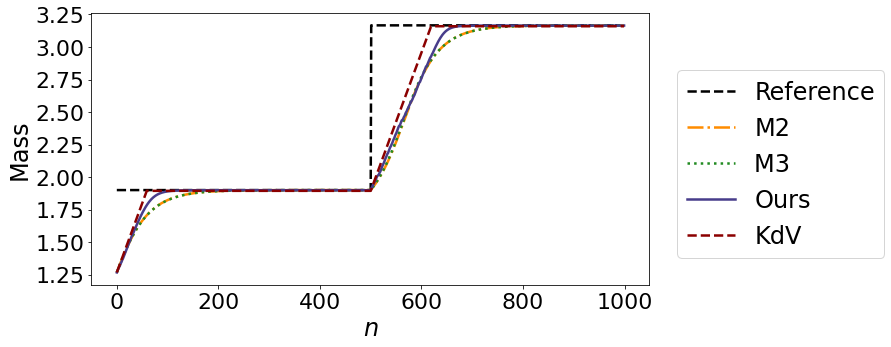

In [124]:
plt.figure(figsize=(10,5))
plt.plot(mass_ref, label='Reference', linestyle='--', color=ref_color, linewidth=linewidth)

plt.plot(linear_kdv_opt_mass, label='M2', color=linear_curve, linestyle=linear_linestyle, linewidth=linewidth)
plt.plot(bilinear_kdv_opt_mass, label='M3 ', color=bilinear_curve,linestyle=bilinear_linestyle, linewidth=linewidth)
plt.plot(pk_kdv_opt_mass, label='Ours', color=pk_curve, linestyle=pk_linestyle, linewidth=linewidth)


plt.plot(kdv_opt_mass, label='KdV',linestyle='--',color=exact_color, linewidth=linewidth)

plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r'$n$', fontsize=label_font)
plt.ylabel('Mass', fontsize=label_font)
# plt.yscale('log')
plt.legend(fontsize=legend_font, loc=(1.05, 0.1))


In [128]:
pk_opt_control_momentum, pk_kdv_opt_momentum_soln = KoopmanMPC(y0=y0_track,
                                                               tau=tau,
                                                               traj_len=traj_len_track,
                                                               soln_ref=momentum_ref,
                                                               kdv_solver=kdv.kdv_solution,
                                                               B=B_momentum,
                                                               loss=mpc_loss_pk,
                                                               lambda_param=lambda_param)

current time step:  0
loss:  0.09972668693731043
current time step:  1
loss:  0.09820737879569455
current time step:  2
loss:  0.09668671649911247
current time step:  3
loss:  0.09517267586211516
current time step:  4
loss:  0.09366978262244492
current time step:  5
loss:  0.0921806048358641
current time step:  6
loss:  0.09070571163801133
current time step:  7
loss:  0.08924545957279462
current time step:  8
loss:  0.0877972409791395
current time step:  9
loss:  0.08635856309728013
current time step:  10
loss:  0.08492281331970325
current time step:  11
loss:  0.08348555177973539
current time step:  12
loss:  0.08204989897819158
current time step:  13
loss:  0.08062397787749777
current time step:  14
loss:  0.07921535294847247
current time step:  15
loss:  0.07782733250012809
current time step:  16
loss:  0.07645884386135696
current time step:  17
loss:  0.07510706998238863
current time step:  18
loss:  0.0737676217930845
current time step:  19
loss:  0.07243774014586207
current time 

loss:  0.001235717431002328
current time step:  162
loss:  0.0011931587076157667
current time step:  163
loss:  0.001151728486570476
current time step:  164
loss:  0.0011115449502951055
current time step:  165
loss:  0.0010729390006282721
current time step:  166
loss:  0.0010359922895995814
current time step:  167
loss:  0.0010005838552128788
current time step:  168
loss:  0.000966377417707597
current time step:  169
loss:  0.0009329998650945063
current time step:  170
loss:  0.0009003526335721307
current time step:  171
loss:  0.0008685809017735816
current time step:  172
loss:  0.0008379467123809894
current time step:  173
loss:  0.0008085715310749131
current time step:  174
loss:  0.0007803627218179097
current time step:  175
loss:  0.0007530438663157254
current time step:  176
loss:  0.0007266921295156777
current time step:  177
loss:  0.0007010443923071754
current time step:  178
loss:  0.0006763879995414926
current time step:  179
loss:  0.0006527261182793148
current time step:  

loss:  5.321549723386913e-06
current time step:  316
loss:  5.122099165936214e-06
current time step:  317
loss:  4.93282118934429e-06
current time step:  318
loss:  4.761605988206307e-06
current time step:  319
loss:  4.613056238282668e-06
current time step:  320
loss:  4.478080844559633e-06
current time step:  321
loss:  4.341314591581743e-06
current time step:  322
loss:  4.188579929173021e-06
current time step:  323
loss:  4.040036094133854e-06
current time step:  324
loss:  3.899869738223799e-06
current time step:  325
loss:  3.7601912282508462e-06
current time step:  326
loss:  3.6345818041965633e-06
current time step:  327
loss:  3.534168171302679e-06
current time step:  328
loss:  3.4278315450513764e-06
current time step:  329
loss:  3.3297770228980414e-06
current time step:  330
loss:  3.222450619849812e-06
current time step:  331
loss:  3.1371142915051623e-06
current time step:  332
loss:  3.022465799454807e-06
current time step:  333
loss:  2.908612309970488e-06
current time 

loss:  3.0445469968313e-08
current time step:  470
loss:  3.326996264392704e-08
current time step:  471
loss:  2.471954821125271e-08
current time step:  472
loss:  2.3114106741944063e-08
current time step:  473
loss:  3.004212789873894e-08
current time step:  474
loss:  2.7417417338863915e-08
current time step:  475
loss:  3.8307547603798105e-08
current time step:  476
loss:  3.164058579625676e-08
current time step:  477
loss:  2.8742296333863117e-08
current time step:  478
loss:  2.651747857095759e-08
current time step:  479
loss:  2.5837347610052028e-08
current time step:  480
loss:  2.680082821630943e-08
current time step:  481
loss:  2.795299561634871e-08
current time step:  482
loss:  2.7922776175531266e-08
current time step:  483
loss:  2.5989897142184754e-08
current time step:  484
loss:  2.3783009771044147e-08
current time step:  485
loss:  2.618446974696399e-08
current time step:  486
loss:  2.3879602206661393e-08
current time step:  487
loss:  2.4377718032601687e-08
current t

loss:  0.018365428029913988
current time step:  631
loss:  0.017081359388012564
current time step:  632
loss:  0.0158662712771195
current time step:  633
loss:  0.014716945728722714
current time step:  634
loss:  0.01364147742073517
current time step:  635
loss:  0.01264392700116512
current time step:  636
loss:  0.01171999286572458
current time step:  637
loss:  0.01086533293873649
current time step:  638
loss:  0.010071286160755819
current time step:  639
loss:  0.009329433905060715
current time step:  640
loss:  0.008634504080227687
current time step:  641
loss:  0.007982420348433963
current time step:  642
loss:  0.007371647388440628
current time step:  643
loss:  0.006799880778384873
current time step:  644
loss:  0.006267286095549932
current time step:  645
loss:  0.0057756205636020465
current time step:  646
loss:  0.005326082766502852
current time step:  647
loss:  0.004913109755321385
current time step:  648
loss:  0.0045321484163304
current time step:  649
loss:  0.0041788646

loss:  3.2600063461249427e-08
current time step:  786
loss:  2.908814162805645e-08
current time step:  787
loss:  2.383955780363743e-08
current time step:  788
loss:  2.1837855870164848e-08
current time step:  789
loss:  2.104831061385053e-08
current time step:  790
loss:  2.192000681532866e-08
current time step:  791
loss:  2.361850514297465e-08
current time step:  792
loss:  2.4293406721877647e-08
current time step:  793
loss:  2.345439986015968e-08
current time step:  794
loss:  1.619242331232164e-08
current time step:  795
loss:  1.4504909458244223e-08
current time step:  796
loss:  1.011740241873905e-08
current time step:  797
loss:  8.584346859647219e-09
current time step:  798
loss:  8.558572051664435e-09
current time step:  799
loss:  7.944383234978164e-09
current time step:  800
loss:  1.4122697322771984e-08
current time step:  801
loss:  1.2894259397867293e-08
current time step:  802
loss:  1.334578162913606e-08
current time step:  803
loss:  1.2620429976791423e-08
current ti

loss:  8.537363980709052e-09
current time step:  940
loss:  3.9123183134125106e-09
current time step:  941
loss:  5.496266059144321e-09
current time step:  942
loss:  4.2187697260366685e-09
current time step:  943
loss:  3.5951233399109704e-09
current time step:  944
loss:  4.227558143185937e-09
current time step:  945
loss:  4.738678058399262e-09
current time step:  946
loss:  6.0362306534493665e-09
current time step:  947
loss:  5.84853688768766e-09
current time step:  948
loss:  4.689356378348188e-09
current time step:  949
loss:  3.4271984123696765e-09
current time step:  950
loss:  3.695409073994349e-09
current time step:  951
loss:  2.6617313710734486e-09
current time step:  952
loss:  1.0118452557126986e-09
current time step:  953
loss:  1.2353974550340933e-09
current time step:  954
loss:  5.893722652902437e-09
current time step:  955
loss:  8.787933513874856e-09
current time step:  956
loss:  4.079418202901202e-09
current time step:  957
loss:  3.3081255579639387e-09
current t

In [132]:
linear_opt_control_momentum, linear_kdv_opt_momentum_soln = KoopmanMPC(y0=y0_track,
                                                               tau=tau,
                                                               traj_len=traj_len_track,
                                                               soln_ref=momentum_ref,
                                                               kdv_solver=kdv.kdv_solution,
                                                               B=B_momentum,
                                                               loss=mpc_loss_linear,
                                                               lambda_param=lambda_param)

current time step:  0
loss:  0.10019331055152017
current time step:  1
loss:  0.10002885181176488
current time step:  2
loss:  0.09986474547163099
current time step:  3
loss:  0.09970007240032025
current time step:  4
loss:  0.09953525097445357
current time step:  5
loss:  0.09936984860637606
current time step:  6
loss:  0.09920397891805285
current time step:  7
loss:  0.09903735738674749
current time step:  8
loss:  0.0988704987803457
current time step:  9
loss:  0.098703673929742
current time step:  10
loss:  0.09853701971445984
current time step:  11
loss:  0.09836983362997247
current time step:  12
loss:  0.09820270916250574
current time step:  13
loss:  0.09803571575837505
current time step:  14
loss:  0.097869230074549
current time step:  15
loss:  0.09770237347284792
current time step:  16
loss:  0.0975361806128538
current time step:  17
loss:  0.09736942533585849
current time step:  18
loss:  0.09720270416291703
current time step:  19
loss:  0.09703585251807405
current time ste

loss:  0.0714263109932371
current time step:  164
loss:  0.0712562847282915
current time step:  165
loss:  0.07108626343874902
current time step:  166
loss:  0.07091637521731918
current time step:  167
loss:  0.0707467347895986
current time step:  168
loss:  0.07057696474617797
current time step:  169
loss:  0.07040681795380473
current time step:  170
loss:  0.07023683084375276
current time step:  171
loss:  0.0700668398961483
current time step:  172
loss:  0.06989702709609859
current time step:  173
loss:  0.06972732357261359
current time step:  174
loss:  0.06955790026352512
current time step:  175
loss:  0.06938934791565132
current time step:  176
loss:  0.06922138636670574
current time step:  177
loss:  0.06905416657689963
current time step:  178
loss:  0.06888743864832789
current time step:  179
loss:  0.0687210434715025
current time step:  180
loss:  0.06855517971653556
current time step:  181
loss:  0.06839021153810677
current time step:  182
loss:  0.06822591958369331
current t

loss:  0.049007820037240024
current time step:  325
loss:  0.04890517981364792
current time step:  326
loss:  0.04880293115161707
current time step:  327
loss:  0.048701272544187976
current time step:  328
loss:  0.04860031315431121
current time step:  329
loss:  0.04849965265026723
current time step:  330
loss:  0.048399208067240525
current time step:  331
loss:  0.04829884706622414
current time step:  332
loss:  0.04819876859380706
current time step:  333
loss:  0.048099186767194074
current time step:  334
loss:  0.047999857476530586
current time step:  335
loss:  0.04790076768198505
current time step:  336
loss:  0.047801573702540394
current time step:  337
loss:  0.04770268309622203
current time step:  338
loss:  0.04760406803965702
current time step:  339
loss:  0.04750584477491908
current time step:  340
loss:  0.04740778733413241
current time step:  341
loss:  0.04731017586320725
current time step:  342
loss:  0.047212978112508096
current time step:  343
loss:  0.047116563156123

loss:  0.03715758166745218
current time step:  485
loss:  0.03710620677482524
current time step:  486
loss:  0.037055110001088416
current time step:  487
loss:  0.03700432116594696
current time step:  488
loss:  0.036953675260806486
current time step:  489
loss:  0.03690327733486431
current time step:  490
loss:  0.036853251713464166
current time step:  491
loss:  0.036803805132829416
current time step:  492
loss:  0.036754561918501315
current time step:  493
loss:  0.03670560087495112
current time step:  494
loss:  0.036657089375377754
current time step:  495
loss:  0.036608885639889344
current time step:  496
loss:  0.036560810460285906
current time step:  497
loss:  0.03651284638529381
current time step:  498
loss:  0.0364647631319739
current time step:  499
loss:  0.036416633669077936
current time step:  500
loss:  1.4490243098877533
current time step:  501
loss:  1.4472827878828225
current time step:  502
loss:  1.4454816942977464
current time step:  503
loss:  1.4436289532681061


loss:  1.0180785541906543
current time step:  650
loss:  1.0145374088919472
current time step:  651
loss:  1.0109985103558519
current time step:  652
loss:  1.007452945928919
current time step:  653
loss:  1.0039210930865468
current time step:  654
loss:  1.0004006065946662
current time step:  655
loss:  0.996890998582866
current time step:  656
loss:  0.9934186872024289
current time step:  657
loss:  0.9899761248613224
current time step:  658
loss:  0.9865414444835864
current time step:  659
loss:  0.9831151096408757
current time step:  660
loss:  0.9797013322999298
current time step:  661
loss:  0.9763035425080769
current time step:  662
loss:  0.9729148715684048
current time step:  663
loss:  0.9695199286524582
current time step:  664
loss:  0.9661257202392681
current time step:  665
loss:  0.9627161261541813
current time step:  666
loss:  0.9593132769985919
current time step:  667
loss:  0.9558988235213121
current time step:  668
loss:  0.9524725716458577
current time step:  669
lo

loss:  0.5339706923752109
current time step:  815
loss:  0.5318563755272299
current time step:  816
loss:  0.5297460241291212
current time step:  817
loss:  0.5276352252951347
current time step:  818
loss:  0.5255314429947073
current time step:  819
loss:  0.5234402230896706
current time step:  820
loss:  0.5213619865408242
current time step:  821
loss:  0.5192873072435473
current time step:  822
loss:  0.5172251792862783
current time step:  823
loss:  0.5151854803076236
current time step:  824
loss:  0.513168554681302
current time step:  825
loss:  0.5111786133608498
current time step:  826
loss:  0.509204358173639
current time step:  827
loss:  0.5072425600926439
current time step:  828
loss:  0.5053030276322471
current time step:  829
loss:  0.5033789458398519
current time step:  830
loss:  0.5014750970484886
current time step:  831
loss:  0.4995746100357775
current time step:  832
loss:  0.49768257851904174
current time step:  833
loss:  0.49579328262758704
current time step:  834


loss:  0.31155152342303377
current time step:  978
loss:  0.31080990902132527
current time step:  979
loss:  0.3100741269384069
current time step:  980
loss:  0.3093327138063799
current time step:  981
loss:  0.30858404406632356
current time step:  982
loss:  0.3078375254748436
current time step:  983
loss:  0.3070994756056282
current time step:  984
loss:  0.30635395591468684
current time step:  985
loss:  0.3056067791269773
current time step:  986
loss:  0.3048674906323888
current time step:  987
loss:  0.304135901044756
current time step:  988
loss:  0.3034049121437996
current time step:  989
loss:  0.3026736404917972
current time step:  990
loss:  0.3019519353405816
current time step:  991
loss:  0.30123424557493983
current time step:  992
loss:  0.3005222889866311
current time step:  993
loss:  0.2998233366705404
current time step:  994
loss:  0.29913196941548204
current time step:  995
loss:  0.29845488365881584
current time step:  996
loss:  0.2977847693585091
current time step:

In [133]:
bilinear_opt_control_momentum, bilinear_kdv_opt_momentum_soln = KoopmanMPC(y0=y0_track,
                                                               tau=tau,
                                                               traj_len=traj_len_track,
                                                               soln_ref=momentum_ref,
                                                               kdv_solver=kdv.kdv_solution,
                                                               B=B_momentum,
                                                               loss=mpc_loss_bilinear,
                                                               lambda_param=lambda_param)

current time step:  0
loss:  0.10001605991067346
current time step:  1
loss:  0.09925306953292347
current time step:  2
loss:  0.0984828763699658
current time step:  3
loss:  0.09771138230288898
current time step:  4
loss:  0.09694383162191998
current time step:  5
loss:  0.09618083862500255
current time step:  6
loss:  0.09541896489296911
current time step:  7
loss:  0.09465306800447514
current time step:  8
loss:  0.09388365000685375
current time step:  9
loss:  0.09311145212851978
current time step:  10
loss:  0.09233818562353036
current time step:  11
loss:  0.09156708848028355
current time step:  12
loss:  0.09079658757884561
current time step:  13
loss:  0.09002476569539511
current time step:  14
loss:  0.08925253714615501
current time step:  15
loss:  0.08847957962005965
current time step:  16
loss:  0.08770805767997598
current time step:  17
loss:  0.0869427147655311
current time step:  18
loss:  0.08618357838629034
current time step:  19
loss:  0.08542956706273896
current time

loss:  0.016637930523960183
current time step:  163
loss:  0.016400958791196223
current time step:  164
loss:  0.016167288312286622
current time step:  165
loss:  0.015936584053625
current time step:  166
loss:  0.015708625860682585
current time step:  167
loss:  0.01548257174226846
current time step:  168
loss:  0.01525714778573489
current time step:  169
loss:  0.015032597419542241
current time step:  170
loss:  0.014809321511202182
current time step:  171
loss:  0.014587982153964086
current time step:  172
loss:  0.014369416155474988
current time step:  173
loss:  0.014153556270006168
current time step:  174
loss:  0.013940114574148165
current time step:  175
loss:  0.013728914484562944
current time step:  176
loss:  0.013519463706393297
current time step:  177
loss:  0.013311811251316795
current time step:  178
loss:  0.013106609321991316
current time step:  179
loss:  0.01290391964126128
current time step:  180
loss:  0.012703717130271427
current time step:  181
loss:  0.012506229

loss:  0.0012628195134946063
current time step:  320
loss:  0.0012417700559194237
current time step:  321
loss:  0.0012209818086834276
current time step:  322
loss:  0.0012004027148305656
current time step:  323
loss:  0.0011800520968797113
current time step:  324
loss:  0.0011600377013699689
current time step:  325
loss:  0.0011404247077084473
current time step:  326
loss:  0.0011211828601660953
current time step:  327
loss:  0.001102280534129863
current time step:  328
loss:  0.0010836301097002048
current time step:  329
loss:  0.001065106910089425
current time step:  330
loss:  0.0010467436231346742
current time step:  331
loss:  0.0010286072344696698
current time step:  332
loss:  0.0010107298866854726
current time step:  333
loss:  0.0009931636283719008
current time step:  334
loss:  0.0009759221859053537
current time step:  335
loss:  0.0009589246752147856
current time step:  336
loss:  0.0009421352449683017
current time step:  337
loss:  0.000925558418503638
current time step:  

loss:  8.237474042841167e-05
current time step:  474
loss:  8.10179361291158e-05
current time step:  475
loss:  7.968819915337305e-05
current time step:  476
loss:  7.838214582771843e-05
current time step:  477
loss:  7.709842631030426e-05
current time step:  478
loss:  7.583437350143577e-05
current time step:  479
loss:  7.458888827494404e-05
current time step:  480
loss:  7.336332609608394e-05
current time step:  481
loss:  7.21570014958845e-05
current time step:  482
loss:  7.097221604585006e-05
current time step:  483
loss:  6.981460134714803e-05
current time step:  484
loss:  6.868214268214589e-05
current time step:  485
loss:  6.757223484549784e-05
current time step:  486
loss:  6.648115437561908e-05
current time step:  487
loss:  6.540367443376176e-05
current time step:  488
loss:  6.433860319384164e-05
current time step:  489
loss:  6.328767831827821e-05
current time step:  490
loss:  6.224888282597116e-05
current time step:  491
loss:  6.12239843571481e-05
current time step:  

loss:  0.03320337140333126
current time step:  636
loss:  0.031748512573918385
current time step:  637
loss:  0.030375019729651717
current time step:  638
loss:  0.029044435807672152
current time step:  639
loss:  0.02775185829391798
current time step:  640
loss:  0.026525055202282148
current time step:  641
loss:  0.02533853425287852
current time step:  642
loss:  0.024178570982681287
current time step:  643
loss:  0.023079550708360215
current time step:  644
loss:  0.022019287952257573
current time step:  645
loss:  0.02099047314469895
current time step:  646
loss:  0.02002757947231549
current time step:  647
loss:  0.019086258298764473
current time step:  648
loss:  0.01820342660976015
current time step:  649
loss:  0.017349948677759495
current time step:  650
loss:  0.01652873403952564
current time step:  651
loss:  0.015753094697092723
current time step:  652
loss:  0.014994749956013582
current time step:  653
loss:  0.014278796156387193
current time step:  654
loss:  0.0135974476

loss:  1.6930359211098667e-05
current time step:  792
loss:  1.621469463014266e-05
current time step:  793
loss:  1.5511948827338965e-05
current time step:  794
loss:  1.484542501591661e-05
current time step:  795
loss:  1.4201038486185459e-05
current time step:  796
loss:  1.3581370804857992e-05
current time step:  797
loss:  1.2999959378596162e-05
current time step:  798
loss:  1.2455744139609777e-05
current time step:  799
loss:  1.193718539285272e-05
current time step:  800
loss:  1.1442116209279504e-05
current time step:  801
loss:  1.0967562318428568e-05
current time step:  802
loss:  1.0505568918360938e-05
current time step:  803
loss:  1.0065480459708327e-05
current time step:  804
loss:  9.643312268184976e-06
current time step:  805
loss:  9.242555647972697e-06
current time step:  806
loss:  8.859671555861594e-06
current time step:  807
loss:  8.502027898769897e-06
current time step:  808
loss:  8.153718309935055e-06
current time step:  809
loss:  7.816533007750849e-06
current

loss:  7.232526737708492e-08
current time step:  946
loss:  7.083011226585117e-08
current time step:  947
loss:  6.937217731632097e-08
current time step:  948
loss:  6.746750374767174e-08
current time step:  949
loss:  6.52894619361451e-08
current time step:  950
loss:  6.431891946045674e-08
current time step:  951
loss:  6.292521245805132e-08
current time step:  952
loss:  6.137732489672112e-08
current time step:  953
loss:  6.054126156727457e-08
current time step:  954
loss:  5.988925517120606e-08
current time step:  955
loss:  5.824049167760773e-08
current time step:  956
loss:  5.689832165698122e-08
current time step:  957
loss:  5.545997841506559e-08
current time step:  958
loss:  5.379718008134492e-08
current time step:  959
loss:  5.2566357544131815e-08
current time step:  960
loss:  5.081132315837584e-08
current time step:  961
loss:  5.000921570608542e-08
current time step:  962
loss:  4.9897997042782155e-08
current time step:  963
loss:  4.802129193147702e-08
current time ste

In [134]:
pk_kdv_opt_momentum = dx * tf.reduce_sum(tf.square(pk_kdv_opt_momentum_soln), axis=-1)
linear_kdv_opt_momentum = dx * tf.reduce_sum(tf.square(linear_kdv_opt_momentum_soln), axis=-1)
bilinear_kdv_opt_momentum = dx * tf.reduce_sum(tf.square(bilinear_kdv_opt_momentum_soln), axis=-1)

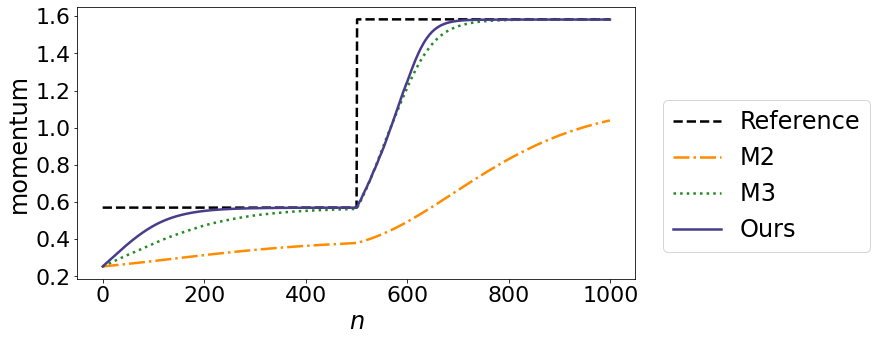

In [135]:
plt.figure(figsize=(10,5))
plt.plot(momentum_ref, label='Reference', linestyle='--', color=ref_color, linewidth=linewidth)

plt.plot(linear_kdv_opt_momentum, label='M2', color=linear_curve, linestyle=linear_linestyle, linewidth=linewidth)
plt.plot(bilinear_kdv_opt_momentum, label='M3 ', color=bilinear_curve,linestyle=bilinear_linestyle, linewidth=linewidth)
plt.plot(pk_kdv_opt_momentum, label='Ours', color=pk_curve, linestyle=pk_linestyle, linewidth=linewidth)


plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r'$n$', fontsize=label_font)
plt.ylabel('momentum', fontsize=label_font)
plt.legend(fontsize=legend_font, loc=(1.05, 0.1))


# Controllability

In [136]:
# Randomly sample control
np.random.seed(seed=111)
n_control_samples = 2000
control_samples = np.random.uniform(low=0, high=1, size=(n_control_samples, param_dim)) * (umax - umin) + umin

In [137]:
pk_K_matrix = solver_pk.model_K_u(control_samples)

In [138]:
identity_matrix = np.eye(N=pk_K_matrix.shape[-1])

pk_A_matrix = (pk_K_matrix - identity_matrix) / T

pk_A_vector = tf.reshape(pk_A_matrix, shape=(pk_A_matrix.shape[0], pk_A_matrix.shape[-1]*pk_A_matrix.shape[-1]))

rank = np.linalg.matrix_rank(pk_A_vector)

U, S, VT = np.linalg.svd(pk_A_vector)

In [139]:
pk_A_vector.shape

TensorShape([2000, 36])

In [140]:
np.sum(S > 1e-5)

36

Text(0, 0.5, '$\\sigma_{i}$')

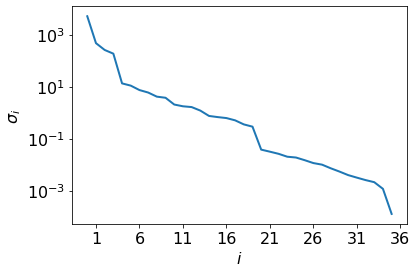

In [142]:
label_font = 16
ticks_font = 16

np.linspace(1,36,8)

plt.plot(S, linewidth=2)
plt.yscale('log')

custom_xticks = np.linspace(1,36,8)
plt.xticks(custom_xticks, fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)

 
plt.xlabel(r'$i$', fontsize=label_font)
plt.ylabel(r'$\sigma_{i}$', fontsize=label_font)
